In [1]:
## First install and load if necessary the following packages

packages = c("tidyverse", "data.table",
             "ggthemes")

## Now load or install&load all
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

Loading required package: tidyverse
Warning message:
"package 'tidyverse' was built under R version 3.6.3"Error: package or namespace load failed for 'tidyverse' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace 'rlang' 0.4.6 is already loaded, but >= 0.4.10 is required
Installing package into 'C:/Users/maxim/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
also installing the dependencies 'jsonlite', 'pillar', 'rlang'




  There is a binary version available but the source version is later:
       binary source needs_compilation
pillar  1.6.0  1.6.1             FALSE

package 'jsonlite' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'jsonlite'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\maxim\Documents\R\win-library\3.6\00LOCK\jsonlite\libs\x64\jsonlite.dll nach C:\Users\maxim\Documents\R\win-library\3.6\jsonlite\libs\x64\jsonlite.dll zu kopieren: Permission denied"Warning message:
"restored 'jsonlite'"

package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\maxim\Documents\R\win-library\3.6\00LOCK\rlang\libs\x64\rlang.dll nach C:\Users\maxim\Documents\R\win-library\3.6\rlang\libs\x64\rlang.dll zu kopieren: Permission denied"Warning message:
"restored 'rlang'"

package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\maxim\AppData\Local\Temp\RtmpeSRcL3\downloaded_packages


installing the source package 'pillar'

Warning message in install.packages(x, dependencies = TRUE):
"installation of package 'pillar' had non-zero exit status"Warning message:
"package 'tidyverse' was built under R version 3.6.3"

ERROR: Error: package or namespace load failed for 'tidyverse' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace 'rlang' 0.4.6 is already loaded, but >= 0.4.10 is required


In [3]:
library("data.table")
library("tidyverse")
library("ggthemes")

for (k in seq(2002,2019)){
  my_url<- paste("https://raw.githubusercontent.com/smalldatascience/Versicherungsstatistik/master/data_en/statistic_", k,".txt", sep="")
  hhh <- fread(my_url)
  #assign(paste("myfile", k, sep = ""), hhh)
  if (k==2002) allData <- hhh else allData <- rbind(allData, hhh)
}
rm(hhh, k,my_url)

##################################### Data sorting #########################

myData <- as_tibble(allData) %>% 
  dplyr::filter(grepl("Claims ratios",Tabelle)) %>%    ## filter out only claims ratios
  select(-`Insurance undertaking`) %>%
  mutate("categoryy"=unlist(map(strsplit(Tabelle, '\"\"'),2))) %>%
  mutate("category1"=unlist(map(strsplit(category, "!"),1))) %>% ##unterteile kategory "nach Zeile" original data
  mutate("direct/nonReinsurance" = grepl("-direct",category1)) %>% 
  mutate("category11"=unlist(map(strsplit(category1, "-direct"),1))) %>%
  mutate("category0"=unlist(map(strsplit(category11, "-inwards reinsurance"),1))) %>%
  mutate("category2"=unlist(map(strsplit(category, "!"),2))) %>%
  mutate("category3"=unlist(map(strsplit(category, "!"),3))) %>% 
  select(-c(category,category11, category1))

myData <-  pivot_wider(myData, id_cols = names(myData)[-2] , names_from = "category3", values_from = "value")

myData <- myData %>% 
  mutate_at(c("Earned premiums", "Claims"), function(x) x/1000)

##filter out inwards reinsurance 
myData_direct <- dplyr::filter(myData, `direct/nonReinsurance` == TRUE)
myData_indirect <- dplyr::filter(myData, `direct/nonReinsurance` == FALSE)


####### myData_direct in gross and net data ...
gross_data <- myData_direct %>% 
  filter(category2 == "Gross amount") %>% 
  select(-category2) %>% 
  filter(!near(`Earned premiums`,0))
 
net_data <- myData %>% 
  filter(category2 != "Gross amount") %>% 
  select(-category2) %>% 
  filter(!near(`Earned premiums`,0)) 

#################################################################### 

gross_sum <- gross_data %>%  
  group_by(year) %>% 
  summarize(sumPrem = sum(`Earned premiums`)/1000,  sumClaim = sum(Claims)/1000) %>%   ## summarize the mean over all insurance companies and categories
  mutate(sumratio = sumClaim/sumPrem) %>% 
  ungroup() 

gross_sum1 <-pivot_longer(gross_sum, cols=c("sumPrem","sumClaim", "sumratio")) %>% 
  filter(name != "sumratio")

ggplot(data=gross_sum1)+
  geom_col(aes(x = year, y = value, 
               group=factor(name, levels = c('sumPrem', 'sumClaim')),
               fill=name),
           position = "dodge" )  +
  scale_fill_brewer(palette="Blues", labels=c("Claims","Premiums")) +
  labs(x="Year", y= "Euro (in millions) " ) +
  theme_dark()+
  geom_line(data=gross_sum, aes(x=year, y= sumratio*10000), col="red")+
  scale_y_continuous(sec.axis = sec_axis(~./10000, name = "Claims/Premium Ratio in [%]"))


Warning message:
"package 'tidyverse' was built under R version 3.6.3"

ERROR: Error: package or namespace load failed for 'tidyverse' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace 'rlang' 0.4.6 is already loaded, but >= 0.4.10 is required


In [10]:

###finde heraus welche die 10 größten kategorien sind
cat_sum <- gross_data %>%  
  group_by(categoryy) %>% 
  summarize(sumPrem = sum(`Earned premiums`),  sumClaim = sum(Claims)) %>%
  ## summarize the mean over all insurance companies.. (in year and categoryy group)
  mutate(meanratio = sumClaim/sumPrem) %>% 
  mutate("anteil" = sumPrem/sum(sumPrem)) %>% 
  ungroup() %>%  
  arrange(desc(anteil))

Top8<- cat_sum$categoryy[1:8]

otherfunc<-function(x) {
  for ( k in 1:length(x)){
    if (!(x[k] %in% Top8)) x[k]="other categories"
  }
  return(x)
}
otherfunc("hello")

gross_data2 <-gross_data
gross_data2$categoryy <- otherfunc(gross_data$categoryy)
rm(otherfunc)

####erstelle Plotting Data...
cat_sum <- gross_data2 %>%  
  group_by(year, categoryy) %>% 
  summarize(sumPrem = sum(`Earned premiums`),  sumClaim = sum(Claims)) %>%
  ## summarize the mean over all insurance companies.. (in year and categoryy group)
  mutate(meanratio = sumClaim/sumPrem) %>% 
  ungroup() %>% 
  group_by(year) %>% 
  mutate("anteil" = sumPrem/sum(sumPrem)) %>% 
  arrange(desc(anteil)) %>% 
  #filter(row_number()%in%c(1:7)) %>% 
  ungroup() %>% 
  mutate_at("sumPrem", function(x) x/1000000)

library("ggthemes")
# stacked area chart
t<- ggplot(cat_sum, aes(x=year, y=sumPrem, fill=categoryy)) + 
  geom_area() +
  labs(x="Year", y= "Euro (in millions) " )  


dd <- t + theme_tufte() + scale_fill_economist()
dd
png("plot2.png",
    width = 800, height = 450)
print(dd)
dev.off()


ERROR: Error in gross_data %>% group_by(categoryy) %>% summarize(sumPrem = sum(`Earned premiums`), : konnte Funktion "%>%" nicht finden


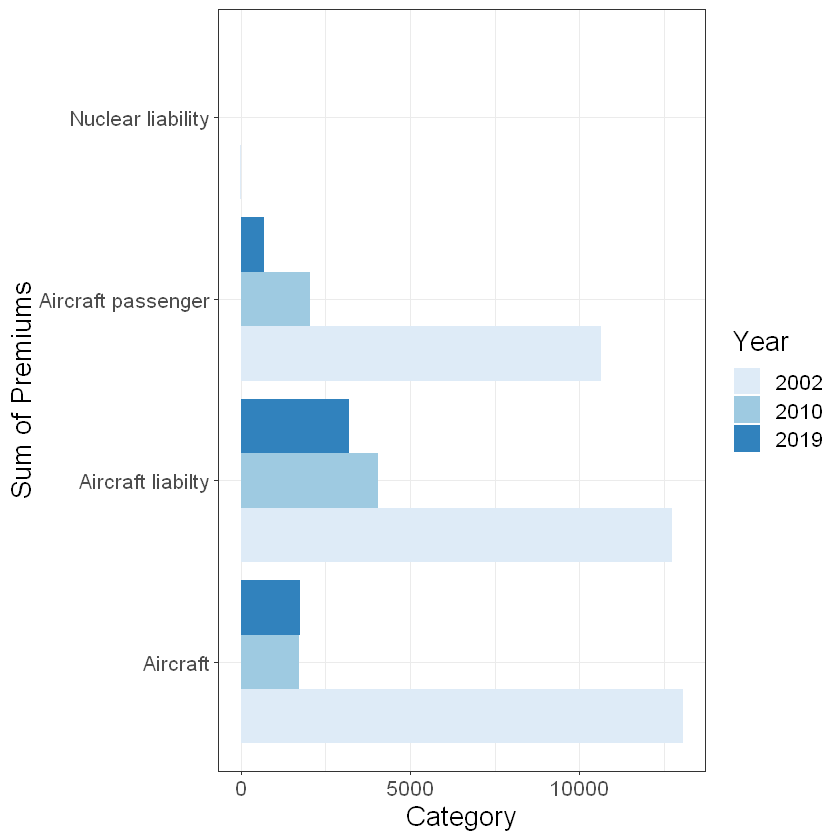

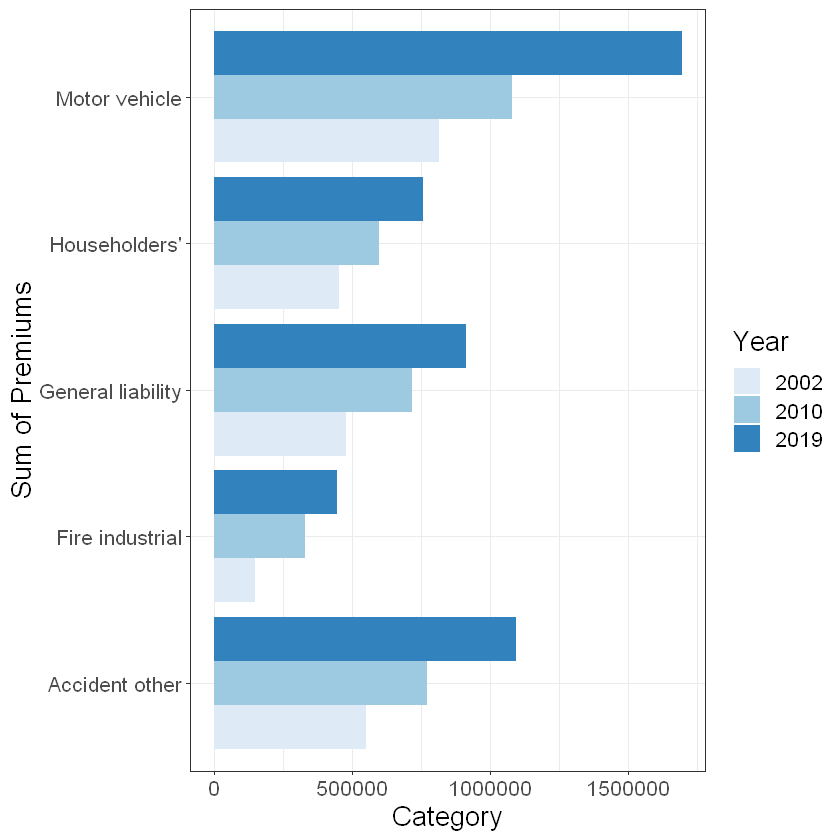

In [34]:
###find out the top categories
prem_change <- gross_data %>%  
  select(c(1,2,3,4,6,7)) %>% 
  filter(near(year,2002) | near(year,2019) ) %>% 
  filter(categoryy != "Accident according to the technical principles of life assurance")


prem_change <- pivot_wider(prem_change, id_cols = names(prem_change)[-3] , names_from = "year", values_from = "Earned premiums")
prem_change <- replace_na(prem_change, list("2002"=0, "2019"=0))

#premium change since 2002
prem_change <- prem_change %>% 
  group_by(categoryy) %>%  
  summarize(sum2019 = sum(`2019`), sum2002=sum(`2002`)) %>%
  ungroup() %>% 
  mutate("change" = sum2019-sum2002)
  
prem_change <- prem_change %>% 
  dplyr::filter(is.finite(change)) %>% 
    arrange(desc(change))
###which are the categories most growing (both present in 2019 and 2002)
Top5<- prem_change$categoryy[1:5]

N<-length(prem_change$categoryy)
Flop4 <- prem_change$categoryy[(N-3):N] ##categories most shrinking

########################### barcharts ##############################

prem_change <- gross_data %>%  
  select(c(1,2,3,4,6,7)) %>% 
  filter(near(year,2002) | near(year,2010) | near(year,2019) ) %>% 
  group_by(year, categoryy) %>% 
  summarize(sumPrem = sum(`Earned premiums`)) %>%
  ungroup()  

prem1 <- prem_change %>% 
  filter(categoryy %in% Flop4) 

ggplot(data=prem1)+
  geom_col(aes(x = categoryy, y = sumPrem, 
               group=year, fill=as.factor(year)),
           position = "dodge" )  +
  scale_fill_brewer(palette="Blues") +
  coord_flip() +
  theme_bw()+theme(text = element_text(size=16)) +
  labs(x="Sum of Premiums", y= "Category", fill="Year")
 
prem1 <- prem_change %>% 
  filter(categoryy %in% Top5) 

ggplot(data=prem1)+
  geom_col(aes(x = categoryy, y = sumPrem, 
               group=year, fill=as.factor(year)),
           position = "dodge" )  +
  scale_fill_brewer(palette="Blues") +
  coord_flip() +
  theme_bw() +theme(text = element_text(size=16)) +
  labs(x="Sum of Premiums", y= "Category", fill="Year")


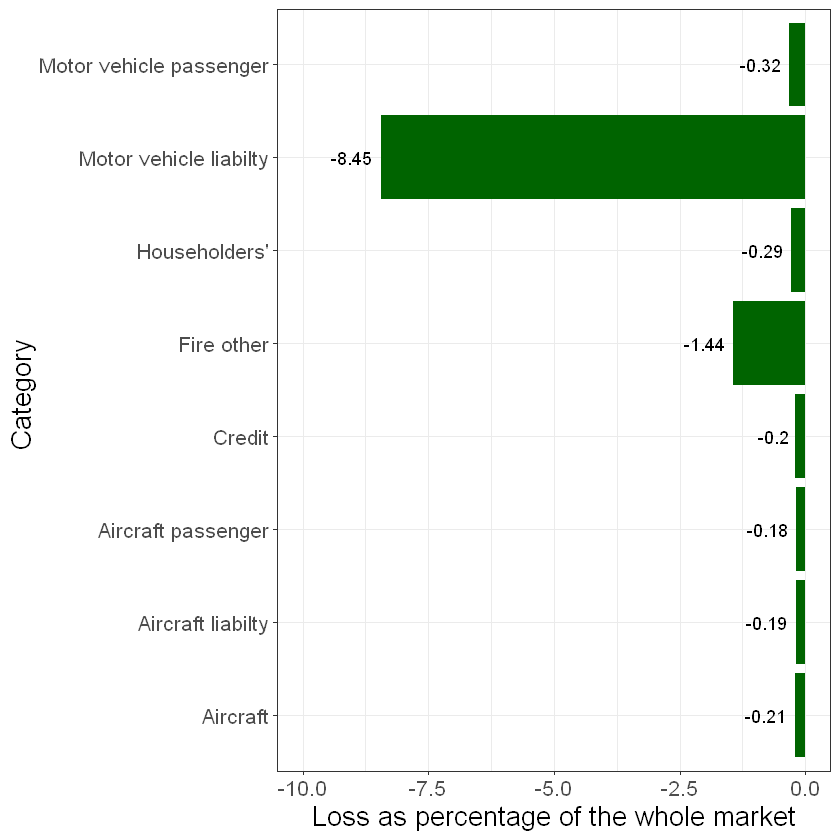

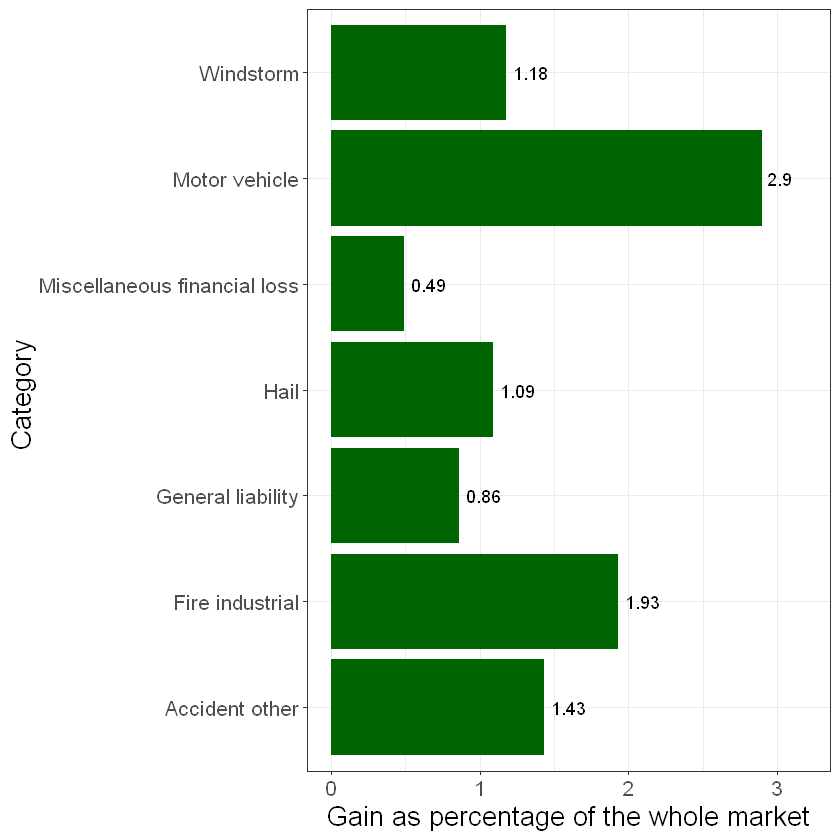

In [33]:
###finde heraus welche die 10 größten kategorien sind
prem_change <- gross_data %>%  
  select(c(1,2,3,4,6,7)) %>% 
  filter(near(year,2002) | near(year,2019) ) %>% 
  filter(categoryy != "Accident according to the technical principles of life assurance")


prem_change <- pivot_wider(prem_change, id_cols = names(prem_change)[-3] , names_from = "year", values_from = "Earned premiums")
prem_change <- replace_na(prem_change, list("2002"=0, "2019"=0))

#premium change since 2002
prem_change <- prem_change %>% 
  group_by(categoryy) %>%  
  summarize(sum2019 = sum(`2019`), sum2002=sum(`2002`)) %>%
  ungroup() %>% 
  mutate("anteil_2019"=100*sum2019/sum(sum2019)) %>% 
  mutate("anteil_2002"=100*sum2002/sum(sum2002)) %>% 
  mutate("change" = anteil_2019 - anteil_2002)%>% 
  arrange(desc(change))

###which are the categories most growing (both present in 2019 and 2002)
Top5<- prem_change$categoryy[1:7]

N<-length(prem_change$categoryy)
Flop5 <- prem_change$categoryy[(N-7):N] ##categories most shrinking

########################### barcharts ##############################


prem1 <- prem_change %>% 
  filter(categoryy %in% Flop5) 

ggplot(data=prem1,aes(x = categoryy, y = change))+
  geom_col(fill="darkgreen" )  +
  theme_bw()+theme(text = element_text(size=16)) +
  labs(x="Category ", y= "Loss as percentage of the whole market", fill="Year") +
  coord_flip()+ 
  geom_text(aes(label = round(change, digits = 2)), vjust = +0.5, hjust=+1.2)+
  ylim(-10,0)

prem1 <- prem_change %>% 
  filter(categoryy %in% Top5) 

ggplot(data=prem1,aes(x = categoryy, y = change))+
  geom_col(fill="darkgreen" )  +
  theme_bw()+theme(text = element_text(size=16)) +
  labs(x="Category ", y= "Gain as percentage of the whole market", fill="Year") +
  coord_flip()+ 
  geom_text(aes(label = round(change, digits = 2)), vjust = +0.5, hjust=-0.2)+
  ylim(0,3.2)



In [7]:
ratios_norm <- gross_data %>% 
   mutate("ratio" = `Claims ratio in %`) %>% 
  select(1,3,4,7,8,10) %>% 
  filter(ratio <=100 & ratio >=0) %>% 
  group_by(categoryy) %>% 
  summarise("volat"=sd(ratio))%>% 
  ungroup() %>% 
  filter(volat != 0) %>% 
  arrange(desc(volat)) %>% 
  print()

top6 <- ratios_norm$categoryy[1:8]
N<- length(ratios_norm$categoryy)
flop6 <- ratios_norm$categoryy[(N-7):N]

ratios_norm <- gross_data %>% 
  mutate("ratio" = `Claims ratio in %`) %>% 
  select(1,3,4,7,8,10) %>% 
  filter(ratio <=100 & ratio >=0) %>% 
  filter(categoryy %in% top6)

 ggplot(data=ratios_norm)+
  geom_boxplot(aes(x=categoryy, y=ratio), fill="blue")+
  coord_flip()+
  labs(x="Category ", y= "Claim/Premium Ratio", fill="Year")+
  theme(text = element_text(size=16))
  


ratios_norm <- gross_data %>% 
  mutate("ratio" = `Claims ratio in %`) %>% 
  select(1,3,4,7,8,10) %>% 
  filter(ratio <=100 & ratio >=0) %>% 
  filter(categoryy %in% flop6)

 ggplot(data=ratios_norm)+
  geom_boxplot(aes(x=categoryy, y=ratio), fill="green")+
  coord_flip()+
  labs(x="Category ", y= "Claim/Premium Ratio", fill="Year")+
  theme(text = element_text(size=16))


ERROR: Error in gross_data %>% mutate(ratio = `Claims ratio in %`) %>% select(1, : konnte Funktion "%>%" nicht finden


In [8]:
ratios <- gross_data %>% 
  filter(categoryy != "Accident according to the technical principles of life assurance") %>% 
  mutate("ratio" = `Claims ratio in %`) %>% 
  select(1,3,4,7,8,10) %>%  
  group_by(categoryy) %>% 
  summarise("outliers"=100*sum(ratio > 100)/sum(ratio <Inf))%>% 
  ungroup() %>% 
  arrange(desc(outliers)) %>% 
  print(n=36)

rat1 <- ratios[1:10,]
ggplot(data=rat1, aes(x = categoryy, y = outliers))+
  geom_col(fill="tomato4" )  +
  theme_bw()+theme(text = element_text(size=16)) +
  labs(x="Category ", y= "Percentage of Companies ending up with a Claim/Premium Ratio >1 ", fill="Year") +
  coord_flip()+
  ylim(0,50)

rat1 <- ratios[27:36,] %>% drop_na()
ggplot(data=rat1, aes(x = categoryy, y = outliers))+
  geom_col(fill="tomato4" )  +
theme_bw()+theme(text = element_text(size=16)) +
  labs(x="Category ", y= "Percentage of Companies ending up with a Claim/Premium Ratio >1 ", fill="Year") +
  coord_flip() + 
  ylim(0,50) 
 


ERROR: Error in gross_data %>% filter(categoryy != "Accident according to the technical principles of life assurance") %>% : konnte Funktion "%>%" nicht finden
